In [1]:
##Lending Club Loan Default
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
import statsmodels.api as sm

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.compat import lzip

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler, Imputer

from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import ks_2samp

from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit

from collections import Counter
from sklearn import metrics, decomposition
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score

%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore") 

#pd.set_option('display.max_columns', None) # Display any number of columns

# Load the data
#df = pd.read_csv('Desktop\\Python\\LoanDefault\\LendingClubLarge.csv', low_memory=True)
df = pd.read_csv('Desktop\\Python\\LoanDefault\\LendingClubLargeCV.csv', low_memory=True)

print(df.shape)
df.head(3)

(4000, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600,3600,3600,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700,24700,24700,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000,20000,20000,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Remove columns where 50% of values are null
fifty_perc = len(df)/2
df = df.dropna(thresh=fifty_perc, axis=1)
df.shape
df.isnull().sum()

id                               0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_title                      189
emp_length                     187
home_ownership                   0
annual_inc                       0
verification_status              0
issue_d                          0
loan_status                      0
pymnt_plan                       0
url                              0
purpose                          0
title                           93
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
fico_range_low                   0
fico_range_high                  0
inq_last_6mths                   0
mths_since_last_deli

In [3]:
# Drop columns which are not necessary for our loan default prediction
drop_columns = ['id', 'emp_title', 'issue_d', 'policy_code', 'title', 'zip_code', 'acc_now_delinq', 'acc_open_past_24mths', 
               'all_util', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
             'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 
             'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'il_util', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
             'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'max_bal_bc', 
             'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_inq', 
             'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 
             'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 
             'num_tl_op_past_12m', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'out_prncp', 
             'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 
             'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bal_il', 'total_bc_limit', 'total_cu_tl', 'total_il_high_credit_limit', 
             'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim', 
                'url', 'sub_grade', 'pub_rec', 'earliest_cr_line']

df = df.drop(drop_columns, axis=1)
df.head(3)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies
0,3600,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Not Verified,Fully Paid,...,7,2765,29.7,13,w,Individual,148.0,128,1,0
1,24700,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Not Verified,Fully Paid,...,22,21470,19.2,38,w,Individual,113.0,192,4,0
2,20000,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,Not Verified,Fully Paid,...,6,7869,56.2,18,w,Joint App,125.0,184,5,0


In [4]:
# Let take a look at the values in our target variable loan_status
df['loan_status'].value_counts()
df.shape

(4000, 26)

In [5]:
# We will remove rows that have values other than Charged Off and Fully Paid as those are not relevant to our analysis
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df.shape

(3550, 26)

In [6]:
df['loan_status'] = df['loan_status'].apply(lambda s: np.int(s == 'Charged Off')) # Converts target to boolean
# The below code does the same as a above but a longer code though easier to understand
#target_bool = df[(df["loan_status"]=='Fully Paid') | (df["loan_status"] == "Charged Off")]
#di = {"Fully Paid": 0, "Charged Off":1} #converting target variable to boolean
#df = target_bool.replace({"loan_status": di})
#df.loan_status.head(25)
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'dti', 'fico_range_low', 'fico_range_high',
       'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'application_type',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [7]:
mapping_dict = {"10+ years": 10, "9 years": 9, "8 years": 8, "7 years": 7, "6 years": 6, "5 years": 5, "4 years": 4,
                "3 years": 3, "2 years": 2, "1 year": 1, "< 1 year": 0, "n/a": 0}
df["emp_length"] = df["emp_length"].replace(mapping_dict)
#df["emp_length"] = df["emp_length"].apply(lambda x:float(x))

# mapping_dict
# Data encoding
#Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
#Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})

#print("Current shape of dataset :", Final_data.shape)
#Final_data.head(15)

In [8]:
df["emp_length"].value_counts()

10    1195
0      350
2      314
3      312
4      216
1      215
5      209
8      184
6      144
9      123
7      116
Name: emp_length, dtype: int64

In [9]:
df.isnull().sum()

loan_amnt                    0
term                         0
int_rate                     0
installment                  0
grade                        0
emp_length                 172
home_ownership               0
annual_inc                   0
verification_status          0
loan_status                  0
purpose                      0
addr_state                   0
dti                          0
fico_range_low               0
fico_range_high              0
mths_since_last_delinq    1720
open_acc                     0
revol_bal                    0
revol_util                   2
total_acc                    0
initial_list_status          0
application_type             0
mo_sin_old_il_acct          85
mo_sin_old_rev_tl_op         0
mort_acc                     0
pub_rec_bankruptcies         0
dtype: int64

In [10]:
# Filling Missing values
#df.fillna(df.mean(), inplace = True)
df.dti.fillna(df.dti.mean(), inplace = True)
df.revol_util.fillna(df.revol_util.mean(), inplace = True)
df.emp_length.fillna(df.emp_length.mean(), inplace = True)
df.mo_sin_old_il_acct.fillna(df.mo_sin_old_il_acct.mean(), inplace = True)
df.mths_since_last_delinq.fillna(df.mths_since_last_delinq.mean(), inplace=True)
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
addr_state                0
dti                       0
fico_range_low            0
fico_range_high           0
mths_since_last_delinq    0
open_acc                  0
revol_bal                 0
revol_util                0
total_acc                 0
initial_list_status       0
application_type          0
mo_sin_old_il_acct        0
mo_sin_old_rev_tl_op      0
mort_acc                  0
pub_rec_bankruptcies      0
dtype: int64

In [11]:
df["emp_length"] = df["emp_length"].apply(lambda x:int(x))
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))  # Convert 36 months and 60 months to integers only 36 and 60
df_new = df
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies
0,3600,36,13.99,123.03,C,10,MORTGAGE,55000.0,Not Verified,0,...,7,2765,29.7,13,w,Individual,148.0,128,1,0
1,24700,36,11.99,820.28,C,10,MORTGAGE,65000.0,Not Verified,0,...,22,21470,19.2,38,w,Individual,113.0,192,4,0
2,20000,60,10.78,432.66,B,10,MORTGAGE,63000.0,Not Verified,0,...,6,7869,56.2,18,w,Joint App,125.0,184,5,0
4,10400,60,22.45,289.91,F,3,MORTGAGE,104433.0,Source Verified,0,...,12,21929,64.5,35,w,Individual,128.0,210,6,0
5,11950,36,13.44,405.18,C,4,RENT,34000.0,Source Verified,0,...,5,8822,68.4,6,w,Individual,338.0,54,0,0


In [12]:
continuous_X = ['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high',
                'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies']

categorical_X = ['grade','home_ownership','verification_status','purpose','addr_state','initial_list_status','application_type']

In [13]:
# Next we will standardize (scale) continuous x variables
scl = StandardScaler()
df_cont = df[continuous_X]
df_cont = scl.fit_transform(df_cont)
df_cont = pd.DataFrame(df_cont, columns=continuous_X)
df_cont.head(3)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_bal,revol_util,total_acc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies
0,-1.293344,-0.520173,0.456392,-1.253879,1.129166,-0.511535,-1.535640,-0.664201,-0.664183,-0.906235,-0.656203,-0.874144,-1.072431,0.396714,-0.630426,-0.379289,-0.347789
1,1.177972,-0.520173,-0.005972,1.488281,1.129166,-0.304194,-0.361614,0.584859,0.584827,1.583678,0.177796,-1.315136,0.934363,-0.297686,0.041804,1.130777,-0.347789
2,0.627489,1.922438,-0.285703,-0.036160,1.129166,-0.345662,-0.972339,-0.039671,-0.039678,-1.072229,-0.428631,0.238836,-0.671072,-0.059606,-0.042224,1.634132,-0.347789


In [14]:
# Next we will convert categorical variables to dummy variables but we don't standardize dummy variables
df_categ = df[categorical_X]
df_categ = pd.get_dummies(df_categ, columns = categorical_X, drop_first=True)
df_categ.head(3)

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [15]:
# Combining two dataframes, but first need to reset the index else the merged columns will generate nan values
df_cont.reset_index(drop=True, inplace=True)
df_categ.reset_index(drop=True, inplace=True)
df_mod = pd.concat([df_cont, df_categ], axis=1) #horizontal_stacking, merging two dataframes

In [16]:
# Finally combining Loan Status column as well
df.reset_index(drop=True, inplace=True)
df_mod['loan_status'] = df['loan_status']
df_mod['loan_status'].value_counts()
df_mod.shape

(3550, 89)

In [17]:
#Data cleaning process is over, now our data is ready to be used for building our model
df_new = df_mod
df_mod.head(3)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,fico_range_low,fico_range_high,open_acc,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App,loan_status
0,-1.293344,-0.520173,0.456392,-1.253879,1.129166,-0.511535,-1.535640,-0.664201,-0.664183,-0.906235,...,0,0,0,0,0,0,0,1,0,0
1,1.177972,-0.520173,-0.005972,1.488281,1.129166,-0.304194,-0.361614,0.584859,0.584827,1.583678,...,0,0,0,0,0,0,0,1,0,0
2,0.627489,1.922438,-0.285703,-0.036160,1.129166,-0.345662,-0.972339,-0.039671,-0.039678,-1.072229,...,0,0,0,0,0,0,0,1,1,0


In [18]:
y = df_mod['loan_status']
X = df_mod.drop('loan_status', axis=1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =10)

In [20]:
# Linear Dependence of Charge-off on the Predictors using Pearson Correlation, F Stat and p value
linear_dep = pd.DataFrame()

# Pearson correlations:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
    
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

In [21]:
# F Statistic and p-value
from sklearn.feature_selection import f_classif  # f_classif returns F Stat and P value both
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col,'FStat'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

In [22]:
# Sort the results by the absolute value of the Pearson correlation:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

In [23]:
# Reset the index:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)
# View the results for the top 20 predictors most correlated with charged_off:
#We can see from table below, variables most highly correalated with Loan Status are: int_rate, Term, Grade D, Fico Scores, Grade E & DTI
linear_dep.head(10)

,variable,pearson_corr,FStat,p_value
0,int_rate,0.317223,277.822245,3.279915e-59
1,term,0.247776,162.410141,4.428292e-36
2,grade_D,0.188242,91.217331,2.969119e-21
3,fico_range_low,-0.142982,51.821655,8.016985e-13
4,fico_range_high,-0.142980,51.819872,8.024123e-13
5,grade_E,0.141406,50.662392,1.429849e-12
6,dti,0.138620,48.647211,3.913986e-12
7,mo_sin_old_rev_tl_op,-0.116446,34.131636,5.824706e-09
8,grade_B,-0.104827,27.587978,1.628574e-07
9,mort_acc,-0.104738,27.540542,1.668559e-07


In [24]:
## Now we will do Feature Selection using RFE and PCA
model = LogisticRegression() # create the RFE model and select 3 attributes
rfe_model = RFE(model, 10)
rfe_fit = rfe_model.fit(X_train, y_train)

print(rfe_fit.ranking_)
temp = pd.Series(rfe_fit.support_, index = X_train.columns)
selected_features_rfe = temp[temp==True].index
print("The selected features as per RFE method are", selected_features_rfe)

[34 21  1 35 75 62 39 60 32 55 36 74 73 67 54 20 76 15 16 14 46  1  1 33
 37 57 78 63 65 72 71 64  6 56 61 22 38 40  9  8 49 43 47 79  4  1 29 30
 31 53 24 68 18  7  5 58  1  1  2 12 13 10 45 51 50  1 48 26 52 27 77  1
 23 41 28  1 11  3 70  1 44 66 19 17 42 25 59 69]
The selected features as per RFE method are Index(['int_rate', 'grade_F', 'grade_G', 'addr_state_DE', 'addr_state_ME',
       'addr_state_MI', 'addr_state_NH', 'addr_state_OK', 'addr_state_SC',
       'addr_state_UT'],
      dtype='object')


In [25]:
from sklearn.decomposition import PCA
#Feature extraction with PCA
pca = PCA(n_components = 10)
pca_fit = pca.fit(X_train)
print("Explained Variance: %s" % pca_fit.explained_variance_ratio_) #summarize components

Explained Variance: [0.17079649 0.14047062 0.08847399 0.078843   0.05928374 0.05650437
 0.04592929 0.04413956 0.04192591 0.03320785]


In [26]:
## Now we look at different MODEL SELECTION techniques
## First we look at Random Forest Randomized Search model and Random Forest Grid Search
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1, X_train.shape[1])
param_rf = dict(max_features=maxFeatures)

rf_rand = RandomizedSearchCV(rf, param_rf, cv=10, scoring='roc_auc', n_iter=len(maxFeatures), random_state=10)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_rf, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', 
                       cv=5, verbose=1, return_train_score=False)

rf_rand.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 87 candidates, totalling 435 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:   20.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1, param_grid={'max_features': r

In [27]:
# Next we plug in the above best parameters derived from the RF model and try to get the accuracy score
rf_rand_estimator = rf_rand.best_estimator_
rf_grid_estimator = rf_grid.best_estimator_

print('Cross validation mean best score for RF Randomized Search: ', (rf_rand.best_score_).round(3))
print('Best parameters set: \n', rf_rand.best_params_)

print('Cross validation mean best score for RF Grid Search: ', (rf_grid.best_score_).round(3))
print('Best parameters set: \n', rf_grid.best_params_)

Cross validation mean best score for RF Randomized Search:  0.697
Best parameters set: 
 {'max_features': 60}
Cross validation mean best score for RF Grid Search:  0.7
Best parameters set: 
 {'max_features': 32}


In [28]:
y_pred_rf_rand = rf_rand_estimator.predict(X_test)
y_prob_rf_rand = rf_rand_estimator.predict_proba(X_test)[:,1]
#y_train_pred_rf_rand = rf_rand_estimator.predict(X_train)
#y_train_prob_rf_rand = rf_rand_estimator.predict_proba(X_train)[:,1]

print("Accuracy score for RF Randomized Search: ", accuracy_score(y_test, y_pred_rf_rand).round(3))
print("ROC score for RF Randomized Search: ", metrics.roc_auc_score(y_test, y_prob_rf_rand).round(3))

y_pred_rf_grid = rf_grid_estimator.predict(X_test)
y_prob_rf_grid = rf_grid_estimator.predict_proba(X_test)[:,1]

print("Accuracy score for RF Grid Search: ", accuracy_score(y_test, y_pred_rf_grid).round(3))
print("ROC score for RF Grid Search: ", metrics.roc_auc_score(y_test, y_prob_rf_grid).round(3))

Accuracy score for RF Randomized Search:  0.821
ROC score for RF Randomized Search:  0.661
Accuracy score for RF Grid Search:  0.821
ROC score for RF Grid Search:  0.683


In [29]:
# Feature Importance using RandomForest Classifier
''' # features = ['int_rate', 'revol_util', 'dti', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'revol_bal', 'loan_amnt', 'total_acc',
'installment', 'annual_inc', 'open_acc', 'fico_range_high', 'term', 'fico_range_low',  'mort_acc', 'emp_length', 
'grade_D', 'home_ownership_RENT', 'verification_status_Verified']  '''

print("Predictors sorted by their score:")
feature_names = sorted(zip (map(lambda z: round(z, 4), rf_rand.best_estimator_.feature_importances_), X_train.columns), reverse=True)
feature_names_df = pd.DataFrame(feature_names)
feature_names_df.reset_index(inplace=False)
feature_names_df.rename(columns={1:'Variable', 0:'Feature Importance'}, inplace=True)
feature_names_df.head(10)

Predictors sorted by their score:


,Feature Importance,Variable
0,0.1084,int_rate
1,0.0703,dti
2,0.0688,revol_bal
3,0.0652,mo_sin_old_il_acct
4,0.0607,mo_sin_old_rev_tl_op
5,0.0545,annual_inc
6,0.0502,revol_util
7,0.0468,installment
8,0.0413,total_acc
9,0.0398,open_acc


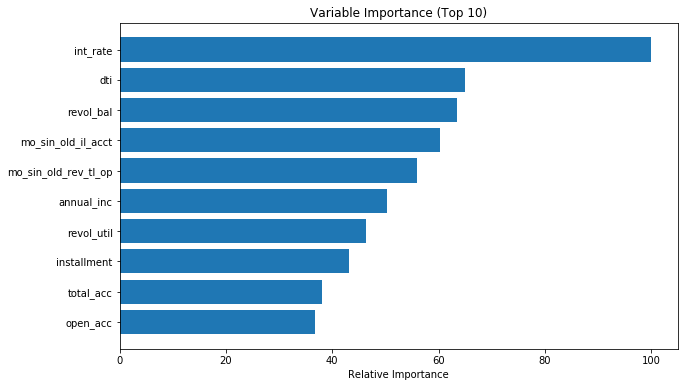

In [30]:
feature_importances = pd.DataFrame(rf_rand.best_estimator_.feature_importances_, index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Normalize The Features and visulize the top 10 features
feature_importance = 100.0 * (rf_rand.best_estimator_.feature_importances_ / rf_rand.best_estimator_.feature_importances_.max())
sorted_idx = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i])[-10:]
pos = np.arange(len(sorted_idx)) + .5
plt.figure(figsize=(10, 6))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.asanyarray(X_train.columns.tolist())[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Top 10)')
plt.show()

In [31]:
# logistic regression with Stochastic Gradient Descent training (SGD)
pipeline_sgdlr = Pipeline([('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=10, warm_start=False))])
param_sgdlr  = {'model__alpha': [10**-5, 10**-1, 10**2], 'model__penalty': ['l1', 'l2']} # A small grid of hyper parameters to search over

In [32]:
# Grid search and train the final model on the whole dataset
grid_sgdlr = GridSearchCV(estimator=pipeline_sgdlr, param_grid=param_sgdlr, scoring='roc_auc', n_jobs=-1, 
                          pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_sgdlr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
                                                      loss='log', max_iter=1000,
                                                      n_iter_no_change=5,
                                                      n_jobs=None, penalty='l2',
                                 

In [33]:
grid_sgdlr_estimator = grid_sgdlr.best_estimator_
print("Best hyperparameters: ", grid_sgdlr.best_params_)  #Best hyperparameters
print("Cross validation mean best score for SGD is: ", (grid_sgdlr.best_score_).round(3)) #Mean cross-validated AUROC score of the best model

y_pred_grid_sgdlr = grid_sgdlr_estimator.predict(X_test)
y_prob_grid_sgdlr = grid_sgdlr_estimator.predict_proba(X_test)[:,1]
#ytrain_pred_grid_sgdlr = grid_sgdlr_estimator.predict(X_train)
#ytrain_prob_grid_sgdlr = grid_sgdlr_estimator.predict_proba(X_train)[:,1]

print("ROC score for SGD Grid Search: ", metrics.roc_auc_score(y_test, y_prob_grid_sgdlr).round(3))
print("Accuracy score for SGD Grid Search: ", accuracy_score(y_test, y_pred_grid_sgdlr).round(3))

Best hyperparameters:  {'model__alpha': 0.1, 'model__penalty': 'l2'}
Cross validation mean best score for SGD is:  0.758
ROC score for SGD Grid Search:  0.749
Accuracy score for SGD Grid Search:  0.826


In [34]:
# Refit the SGD model again using best parameters derived and rank Feature Coefficients
sgd_model= SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=10, warm_start=False, alpha=0.1, penalty='l2')
sgd_model.fit(X_train, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=10, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
temp = sorted(zip(np.round(sgd_model.coef_.reshape(-1), 3), X_train.columns.values), key=lambda x: -abs(x[0]))
weight = [x for x, _ in temp]
feature = [x for _, x in temp]
print("Logistic Regression Coefficients: Top 10")
pd.DataFrame({'weight': weight}, index =feature).head(10)

Logistic Regression Coefficients: Top 10


,weight
int_rate,0.305
term,0.254
mort_acc,-0.134
dti,0.129
mo_sin_old_rev_tl_op,-0.118
grade_D,0.101
fico_range_low,-0.098
fico_range_high,-0.098
revol_bal,-0.090
annual_inc,-0.080


In [36]:
#Recursive Feature Elimination (RFE) using SGDClassifier model best parameters
rfe_sgd = RFE(sgd_model, n_features_to_select=1)
rfe_sgd.fit(X_train, y_train)

RFE(estimator=SGDClassifier(alpha=0.1, average=False, class_weight=None,
                            early_stopping=False, epsilon=0.1, eta0=0.0,
                            fit_intercept=True, l1_ratio=0.15,
                            learning_rate='optimal', loss='log', max_iter=1000,
                            n_iter_no_change=5, n_jobs=None, penalty='l2',
                            power_t=0.5, random_state=10, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False),
    n_features_to_select=1, step=1, verbose=0)

In [37]:
temp = sorted(zip(map(lambda x: round(x, 4), rfe_sgd.ranking_), X_train.columns))
rank = [x for x, _ in temp] #temp stores value of rfe_sgd.ranking_ and X_train.columns. Here ranking from temp is extracted & assigned to rank
feature = [x for _, x in temp] # Here X_train columns names are extracted from temp and assigned to feature
print("Logistic SGD regression RFE Result: Top 10")
pd.DataFrame({'rank': rank}, index = feature).head(10)

Logistic SGD regression RFE Result: Top 10


,rank
int_rate,1
term,2
mort_acc,3
fico_range_low,4
dti,5
mo_sin_old_rev_tl_op,6
fico_range_high,7
grade_D,8
revol_bal,9
loan_amnt,10


In [38]:
# K Nearest Neighbors(KNN) with PCA and Linear Discriminant Analysis (LDA) for dimension reduction
from sklearn import decomposition
pipeline_knn = Pipeline([('pca', decomposition.PCA()), ('model', KNeighborsClassifier(n_jobs=-1))])
pipeline_knn2 = Pipeline([('lda', LinearDiscriminantAnalysis()), ('model', KNeighborsClassifier(n_jobs=-1))])

param_knn = {'pca__n_components': range(3,6), 'model__n_neighbors': [5, 25, 125]}
param_knn2 = {'lda__n_components': range(3,6), 'model__n_neighbors': [5, 25, 125]}

In [39]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_knn, scoring='roc_auc', n_jobs=-1, 
                        pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
#grid_knn2 = GridSearchCV(estimator=pipeline_knn2, param_grid=param_knn2, scoring='roc_auc', n_jobs=-1, 
#                         pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
  

In [40]:
knn_estimator = grid_knn.best_estimator_
print('Best parameters set for KNN:', grid_knn.best_params_)
print('Cross validation mean best score for KNN: ', (grid_knn.best_score_).round(3))

y_pred_knn = knn_estimator.predict(X_test)
y_prob_knn = knn_estimator.predict_proba(X_test)[:,1]
#y_train_pred_knn = knn_estimator.predict(X_train)
#y_train_prob_knn = knn_estimator.predict_proba(X_train)[:,1]

print("ROC score for KN Neighbors: ", metrics.roc_auc_score(y_test, y_prob_knn).round(3))
print("Accuracy score for KN Neighbors: ", accuracy_score(y_test, y_pred_knn).round(3))

Best parameters set for KNN: {'model__n_neighbors': 125, 'pca__n_components': 4}
Cross validation mean best score for KNN:  0.742
ROC score for KN Neighbors:  0.73
Accuracy score for KN Neighbors:  0.82


In [41]:
# Support Vector Machines(SVM) with Grid Search CV
clf_svm = SVC()
#powers = range(0, 3)
#cs = [10**i for i in powers]
#param_grid = dict(C=cs)
param_grid = {'C': [0.1, 1, 10], 'gamma': ['auto','scale'], 'kernel': ['poly','sigmoid','rbf']}

svm_grid = GridSearchCV(clf_svm, param_grid, cv=5, scoring='roc_auc')
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['auto', 'scale'],
                         'kernel': ['poly', 'sigmoid', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [42]:
svm_grid_estimator = svm_grid.best_estimator_
print("Best parameter set: ", svm_grid.best_params_)
print("Cross validation mean best score for SVM: ", (svm_grid.best_score_).round(4))

y_pred_svm_grid = svm_grid_estimator.predict(X_test)
#y_prob_svm_grid = svm_grid_estimator.predict_proba(X_test)[:,1]
y_prob_svm_grid = svm_grid_estimator.decision_function(X_test)
y_train_pred_svm_grid = svm_grid_estimator.predict(X_train)
#y_train_prob_knn = knn_estimator2.predict_proba(X_train)[:,1]

print("ROC score for SVM Grid Search: ", metrics.roc_auc_score(y_test, y_pred_svm_grid).round(3))
print("Accuracy score for SVM Grid Search: ", accuracy_score(y_test, y_pred_svm_grid).round(3))

Best parameter set:  {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Cross validation mean best score for SVM:  0.7004
ROC score for SVM Grid Search:  0.499
Accuracy score for SVM Grid Search:  0.818


,ROC_AUC,MODEL
0,0.697157,Random Forest Randomized Search
1,0.757788,SGD Logistic Regression
2,0.742217,KNNeighbors PCA
3,0.700438,Support Vector Machine GridSearchCV


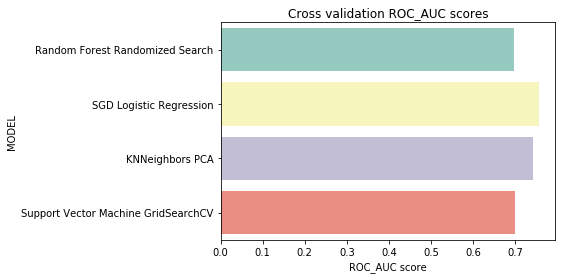

In [43]:
# Model Comparison & Evaluation and Plot the AUROC scores on the training dataset
rocauc_score = [rf_rand.best_score_, grid_sgdlr.best_score_, grid_knn.best_score_, svm_grid.best_score_]
rocauc_res = pd.DataFrame({"ROC_AUC": rocauc_score, "MODEL": ["Random Forest Randomized Search", "SGD Logistic Regression", "KNNeighbors PCA", 
                                                              "Support Vector Machine GridSearchCV"]})
g = sns.barplot("ROC_AUC", "MODEL", data = rocauc_res, palette = "Set3", orient = 'h')
g.set_xlabel("ROC_AUC score")
g = g.set_title("Cross validation ROC_AUC scores")
rocauc_res

,Accuracy Score,MODEL
0,0.820657,Random Forest Randomized Search
1,0.826291,SGD Logistic Regression
2,0.819718,KNNeighbors PCA
3,0.817840,Support Vector Machine GridSearchCV


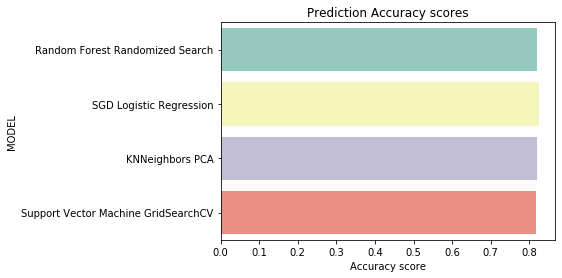

In [44]:
# Model Comparison & Evaluation and Plot the Accuracy scores on the testing dataset
acc_scores = [accuracy_score(y_test, y_pred_rf_rand), accuracy_score(y_test, y_pred_grid_sgdlr), 
              accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_svm_grid)]
accuracy_model = pd.DataFrame({"Accuracy Score": acc_scores, "MODEL": ["Random Forest Randomized Search", "SGD Logistic Regression", 
                                                                           "KNNeighbors PCA", "Support Vector Machine GridSearchCV"]})

g = sns.barplot("Accuracy Score", "MODEL", data = accuracy_model, palette = "Set3", orient = 'h')
g.set_xlabel("Accuracy score")
g = g.set_title("Prediction Accuracy scores")
accuracy_model

In [45]:
def plot_ROC(X_test, y_test, y_prob):
    fpr, tpr, thresh = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob)
    # These are the points at threshold = 0.1~0.5
    x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)] 
    x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]
    fig = plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
    plt.plot(x1, x2, color='k', lw=3, label='threshold = 0.1 ~ 0.5')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Area = {:.2f})'.format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()
    
#plot_ROC(X_test, y_test, y_prob_rf_rand)
#plot_ROC(X_test, y_test, y_prob_grid_sgdlr)
#plot_ROC(X_test, y_test, y_prob_knn)
#plot_ROC(X_test, y_test, y_prob_svm_grid)

In [46]:
def plotAUC(y_test, y_prob, label_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    lw = 1
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr, tpr, color= c, lw=lw, label= label_name +'(AUC=%0.2f)' % roc_auc)    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') 
    plt.legend(loc="lower right")

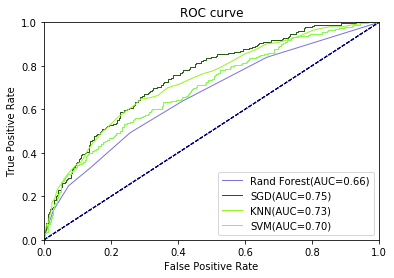

In [47]:
plotAUC(y_test, y_prob_rf_rand, 'Rand Forest') #Random Forest
plotAUC(y_test, y_prob_grid_sgdlr, 'SGD') #SGD
plotAUC(y_test, y_prob_knn, 'KNN' ) # KNN
plotAUC(y_test, y_prob_svm_grid, 'SVM') # SVM 
plt.show()

In [54]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

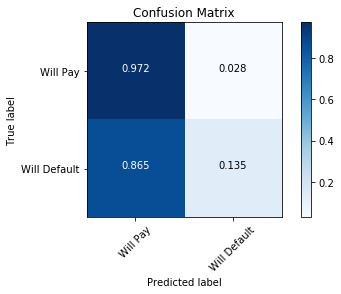

In [67]:
# Confusion Matrix
plot_confusion_matrix(y_pred_rf_rand, normalize=True)

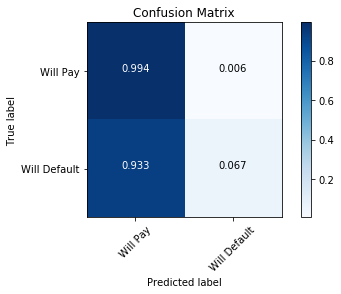

In [63]:
plot_confusion_matrix(y_pred_grid_sgdlr, normalize=True)

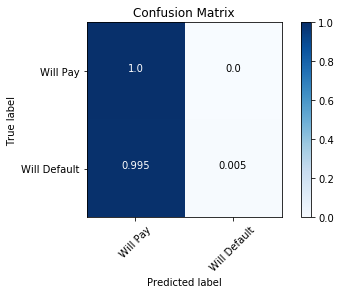

In [69]:
plot_confusion_matrix(y_pred_knn, normalize=True)

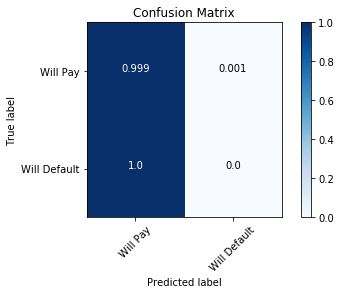

In [70]:
plot_confusion_matrix(y_pred_svm_grid, normalize=True)

In [77]:
# Classification Report: Precision, recall, F1score for all models
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, y_pred_rf_rand, target_names=None))
print("\nSGD",classification_report(y_test, y_pred_grid_sgdlr, target_names=None))
print("\nKNN",classification_report(y_test, y_pred_knn, target_names=None))
print("\nSVM",classification_report(y_test, y_pred_svm_grid, target_names=None))

RF               precision    recall  f1-score   support

           0       0.84      0.97      0.90       872
           1       0.52      0.13      0.21       193

    accuracy                           0.82      1065
   macro avg       0.68      0.55      0.56      1065
weighted avg       0.78      0.82      0.77      1065


SGD               precision    recall  f1-score   support

           0       0.83      0.99      0.90       872
           1       0.72      0.07      0.12       193

    accuracy                           0.83      1065
   macro avg       0.78      0.53      0.51      1065
weighted avg       0.81      0.83      0.76      1065


KNN               precision    recall  f1-score   support

           0       0.82      1.00      0.90       872
           1       1.00      0.01      0.01       193

    accuracy                           0.82      1065
   macro avg       0.91      0.50      0.46      1065
weighted avg       0.85      0.82      0.74      1065


SVM  

In [93]:
# In order to compare the profitability of the model and the profitability the bank actually makes (for the test set), we assume:
# If the loan is granted and the it doesn't get repaid, we lose 1 (y_test = 0 means no default, y_test = 1 means customer defaulted)
# If the loan is granted and the it does get repaid, we gain 1
# If the loan is not granted, gain is 0

bank_score = sum(y_test==0) - sum(y_test==1)  #Bank score = Customer No default - Customer default

# I will pick SGD Logistic Model because it has the highest ROC_AUC and Accuracy scores compared to other models we have above
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_grid_sgdlr).ravel()
score_lr = tn - fn

print("The bank scores {} points".format(bank_score))
print("The Logistic regression model scores {} points".format(score_lr))

The bank scores 679 points
The Logistic regression model scores 687 points


In [ ]:
# Conclusion: 
# Model Selected
# After training with 4 models, SGD Logistic Regression Model has the highest Accuracy as well as ROC_AUC score 

#Features Selected
# After applying different feaure selection methodologies like Pearson Correlation, Fstat, Pvalue, Random Forest RFE, SGD RFE ranking
# The most important features for prediction are: Interest Rate, Term, debt-to-income ratio (dti), FICO score and Revolver balance (revol_bal).